In [3]:
import torch
from torch import nn, optim  # layer / optimizer 라이브러리
import torch.nn.functional as F
from torch.utils.data import DataLoader  # dataset 가져오기
from torchvision import datasets, transforms  # 데이터 전처리
import matplotlib.pyplot as plt  # 시각화
from torch import random
import numpy as np
from torch.utils.data import random_split

# hyper_parameter: 모델을 구성하는 과정에서 개발자가 수정할 수 있는 파라미터
    ex:
    input_size = 28*28 | mnist 사이즈 크기
    hidden_size = 128 : mlp | 히든 레이어 수
    num_classes: 10 | mnist 손글씨 최종 분류 클래스 개수(0~9)
    num_epoches : 10 | 몇 번 학습할지 정하는 학습 단위
    batch_size: 데이터를 학습시킬 때, 일반적인 패턴을 학습시키기 위해서 데이터를 쪼개 구분하는 수
    learning_rate : 0.001 | 모델이 한 번 학습 당 업데이트 되는 정도


In [6]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [7]:
# device = torch.device('mps' if torch.cuda.is_available() else 'cpu') #윈도우 전용#
# print(device)

In [8]:
device = torch.device("mps")
print(device)  # 맥전용

mps


# dataset 로드 및 전처리 정의

In [9]:
# data 값을 0~1 사이 값으로 전처리(normalization)
# 입력 data 값을 tensor로 변환

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)  # mean 0.5, std 0.5

In [10]:
# datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
#   train: paramter에 영향 有
#   download = true : 다운로드해서 실행
#   transform = transform : 위에서 실행한 전처리를 적용한 채로, 데이터를 다운로드

train_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=transform
)
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=transform
)

In [ ]:
input_size = 28 * 28  # mnist 사이즈 크기
hidden_size = 128  # mlp | 히든 레이어 수
num_classes = 10  # mnist 손글씨 최종 분류 클래스 개수(0~9)
num_epochs = 10  # 몇 번 학습할지 정하는 학습 단위
batch_size = 32  # 데이터를 학습시킬 때, 일반적인 패턴을 학습시키기 위해서 데이터를 쪼개 구분하는 수
learning_rate = 0.0001  # 모델이 한 번 학습 당 업데이트 되는 정도

In [12]:
# dataset : train(80%)
#           val(10%)
#           test(10%)

train_size = int(0.8 * (len(train_data)))
val_size = int(len(train_data) - train_size)

# train_data를 train, val로 random 하게 나눔
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # all num of hidden_parameter : 28*28*128+128(bias 수): 100,480
        # 28*28 = input data 수
        # 128: hidden_layer 수
        # +128: bias 수
        # Runner.instance_.distanceRan
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate

        self.input_layer = nn.Linear(input_size, hidden_size)
        # self.sigmoid = nn.Sigmoid() #0에서 1사이의 값, 비선형임 검은색은0 하얀색은255이던 데이터가 검은색은0 하얀색은1로 바뀜 ReLu도 써보기. 활성화 함수.
        self.sigmoid = nn.ReLU()
        self.dropout = nn.Dropout(
            dropout_rate
        )  # 과적합 방지 노드 몇 개 죽여서 새로운 결과 도출
        self.output_layer = nn.Linear(hidden_size, num_classes)

    # model 기능 구조 디자인
    def forward(self, x):
        # x : input_data
        # x resize-> batch_size(784, 1)
        # Linear : only 1차원만 학습; 1차원으로 resize해야 함
        #
        x = x.view(-1, input_size)
        x = self.input_layer(x)
        x = self.sigmoid(x)
        x = self.output_layer(x)

        return x

In [14]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [42]:
model = MLP(input_size, hidden_size, 10)
model.to(device)  # cpu 구동->gpu 구동

MLP(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (sigmoid): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [43]:
# 손실 함수 : 정답 데이터, 추정치 사이의 차이 계산

criterion = nn.CrossEntropyLoss()  # 분류에 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
input_layer_weight = model.input_layer.weight.shape
input_bias_shape = model.input_layer.bias.shape

print(
    f"Input_Layer_weight: {input_layer_weight},\tInput_Layer_bias: {input_bias_shape}"
)

Input_Layer_weight: torch.Size([128, 784]),	Input_Layer_bias: torch.Size([128])


In [16]:
best_val_acc = 0
best_model = None
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # ===== Validation =====
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    # 최적 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()  # 모델 파라미터 저장

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {avg_train_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, "
        f"Val Acc: {val_acc:.2f}%"
    )

Epoch [1/10], Train Loss: 0.1114, Train Acc: 95.92%, Val Acc: 91.90%
Epoch [2/10], Train Loss: 0.0994, Train Acc: 96.32%, Val Acc: 90.88%
Epoch [3/10], Train Loss: 0.0864, Train Acc: 96.93%, Val Acc: 91.43%
Epoch [4/10], Train Loss: 0.0767, Train Acc: 97.21%, Val Acc: 91.51%
Epoch [5/10], Train Loss: 0.0634, Train Acc: 97.69%, Val Acc: 92.10%
Epoch [6/10], Train Loss: 0.0540, Train Acc: 98.05%, Val Acc: 91.97%
Epoch [7/10], Train Loss: 0.0489, Train Acc: 98.28%, Val Acc: 91.41%
Epoch [8/10], Train Loss: 0.0422, Train Acc: 98.51%, Val Acc: 91.78%
Epoch [9/10], Train Loss: 0.0312, Train Acc: 98.97%, Val Acc: 91.38%
Epoch [10/10], Train Loss: 0.0313, Train Acc: 98.84%, Val Acc: 91.58%


# 3주차 과제 ⬇️

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 필요한 라이브러리랑 모듈 임포트 완료!

# ==== 1. 데이터셋 로딩 및 전처리 ====
# (이 부분은 아까 코드랑 동일)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
val_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

batch_size = 100
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# ==== 2. 사용할 디바이스 설정 (M1 맥 최적화!) ====
# GPU가 있으면 'cuda'를 사용하고, M1/M2/M3 맥이면 'mps'를 사용해! 둘 다 없으면 'cpu'!
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # MPS 지원하는지 확인!
    device = torch.device("mps")  # MPS 사용!
else:
    device = torch.device("cpu")
print(f"Using device: {device}")  # 어떤 디바이스 쓰는지 확인!


# ==== 3. CNN 모델 정의 (Batch Normalization과 Dropout 추가) ====
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# ==== 4. 모델 객체 생성 및 디바이스로 이동 ====
model = AdvancedCNN().to(device)
print(f"Model created and moved to {device}")

# ==== 5. 손실 함수 및 옵티마이저 정의 ====
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

best_val_acc = 0
best_model_state_dict = None

# ==== 6. 모델 학습 및 검증 루프 시작! ====
print("Start training!")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # ===== 검증 시작! =====
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            v_loss = criterion(outputs, labels)
            val_loss += v_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state_dict = model.state_dict()
        print(
            f"  --> Validation Accuracy Improved! Saving model state with Val Acc: {val_acc:.2f}%"
        )

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {avg_train_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, "
        f"Val Loss: {avg_val_loss:.4f}, "
        f"Val Acc: {val_acc:.2f}%"
    )

print("Training finished!")

# ==== 7. 학습 완료 후 최적 모델 불러오기 (선택 사항) ====
# (이 부분은 아까 코드랑 동일)
if best_model_state_dict is not None:
    final_model = AdvancedCNN().to(device)
    final_model.load_state_dict(best_model_state_dict)
    print(f"Loaded best model with Val Acc: {best_val_acc:.2f}%")
    # 이제 final_model을 사용해서 예측하거나 최종 테스트를 할 수 있어!
    # final_model.eval() # 사용할 때는 다시 평가 모드로 설정!

Using device: mps
Model created and moved to mps
Start training!
  --> Validation Accuracy Improved! Saving model state with Val Acc: 98.26%
Epoch [1/15], Train Loss: 0.2233, Train Acc: 93.24%, Val Loss: 0.0556, Val Acc: 98.26%
  --> Validation Accuracy Improved! Saving model state with Val Acc: 98.74%
Epoch [2/15], Train Loss: 0.0932, Train Acc: 97.27%, Val Loss: 0.0392, Val Acc: 98.74%
  --> Validation Accuracy Improved! Saving model state with Val Acc: 99.06%
Epoch [3/15], Train Loss: 0.0754, Train Acc: 97.75%, Val Loss: 0.0322, Val Acc: 99.06%
Epoch [4/15], Train Loss: 0.0631, Train Acc: 98.10%, Val Loss: 0.0435, Val Acc: 98.66%
Epoch [5/15], Train Loss: 0.0571, Train Acc: 98.24%, Val Loss: 0.0281, Val Acc: 99.06%
  --> Validation Accuracy Improved! Saving model state with Val Acc: 99.11%
Epoch [6/15], Train Loss: 0.0489, Train Acc: 98.48%, Val Loss: 0.0267, Val Acc: 99.11%
  --> Validation Accuracy Improved! Saving model state with Val Acc: 99.19%
Epoch [7/15], Train Loss: 0.0452,

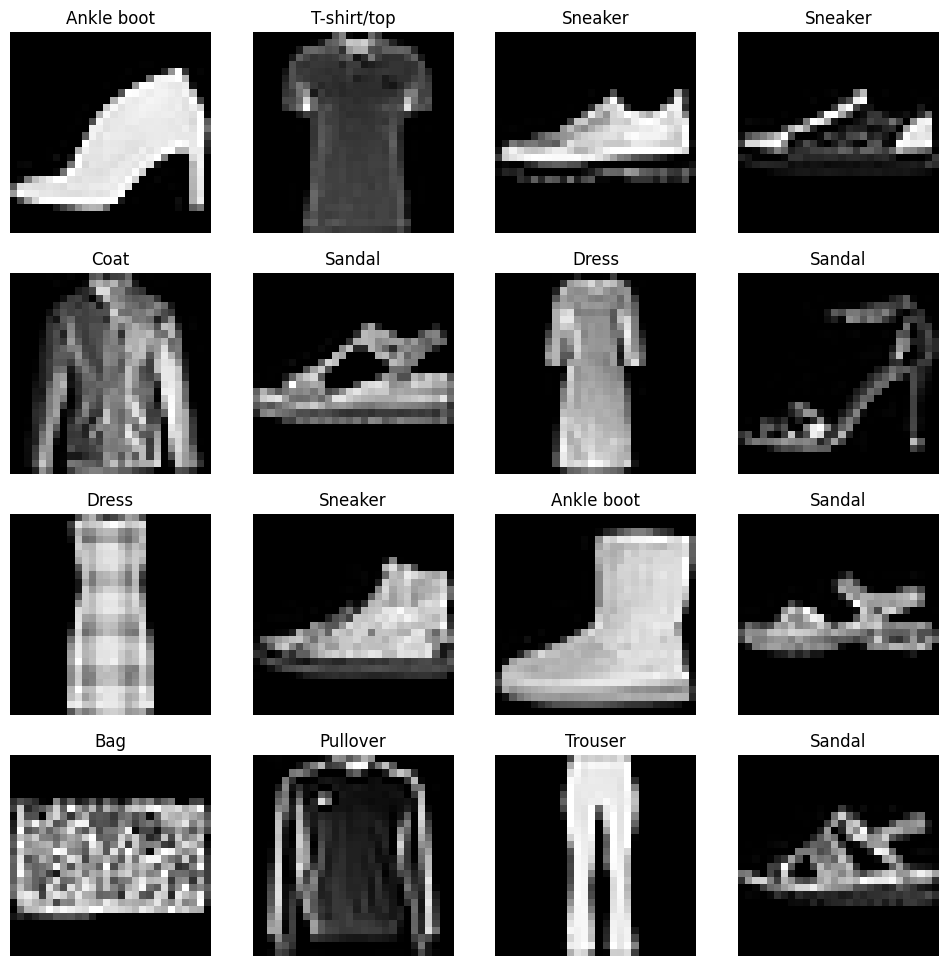

In [ ]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4

# 보통 DataLoader에서 한 배치 가져오기
data_iter = iter(train_loader)
images, labels = next(data_iter)

for i in range(1, cols * rows + 1):
    image = images[i].squeeze().cpu()  # ✅ GPU -> CPU
    label_idx = labels[i].item()
    label = labels_map[label_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(image, cmap="gray")

plt.show()

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 13 * 13, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # 28x28x3
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features


net = ConvNet()
net.to(device)
print(net)

ConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [131]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([8, 1, 3, 3])


In [ ]:
input = torch.randn(1, 1, 28, 28)
out = net(input.to(device))
print(out)

tensor([[-0.2359,  0.0294,  0.1963,  0.0887,  0.2159, -0.1527, -0.2346,  0.0243,
         -0.2118,  0.0214]], device='mps:0', grad_fn=<LinearBackward0>)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [134]:
total_batch = len(train_loader)
print(total_batch)

600


In [135]:
for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(
                "epoch: {}, iter: {}, loss: {}".format(
                    epoch + 1, i + 1, running_loss / 100
                )
            )
            running_loss = 0.0

epoch: 1, iter: 100, loss: 2.136911895275116
epoch: 1, iter: 200, loss: 1.595171378850937
epoch: 1, iter: 300, loss: 1.097698226571083
epoch: 1, iter: 400, loss: 0.8809179788827897
epoch: 1, iter: 500, loss: 0.7912424373626709
epoch: 1, iter: 600, loss: 0.7316463381052017
epoch: 2, iter: 100, loss: 0.6784324771165848
epoch: 2, iter: 200, loss: 0.6699677330255508
epoch: 2, iter: 300, loss: 0.6128032532334328
epoch: 2, iter: 400, loss: 0.6087174609303474
epoch: 2, iter: 500, loss: 0.5663440099358559
epoch: 2, iter: 600, loss: 0.5550397312641144
epoch: 3, iter: 100, loss: 0.5559477078914642
epoch: 3, iter: 200, loss: 0.527424127459526
epoch: 3, iter: 300, loss: 0.5217319360375404
epoch: 3, iter: 400, loss: 0.522183797955513
epoch: 3, iter: 500, loss: 0.4966419646143913
epoch: 3, iter: 600, loss: 0.5095649960637093
epoch: 4, iter: 100, loss: 0.49113125681877134
epoch: 4, iter: 200, loss: 0.4826241013407707
epoch: 4, iter: 300, loss: 0.47356379956007005
epoch: 4, iter: 400, loss: 0.47254809

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11783d510>
Traceback (most recent call last):
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fz/9r0fly8s5gdf_yv2_ds98st40000gn/T/ipykernel_45420/2300249683.py", line 9, in <module>
    loss = loss_fn(outputs, labels.to(device))
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/torch/nn/modules/loss.py", line 1179, in forward
    return F.cross_entropy(input, target, weight=self.weight,
  File "/Users/w4vyx/miniconda3/envs/8lue/lib/python3.10/site-packages/torch/nn/functional.py", line 

In [ ]:
path = "./model.pth"
torch.save(net.state_dict(), path)

In [ ]:
net = ConvNet()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
net.parameters

<bound method Module.parameters of ConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)>

In [ ]:
def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()

    fig = plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

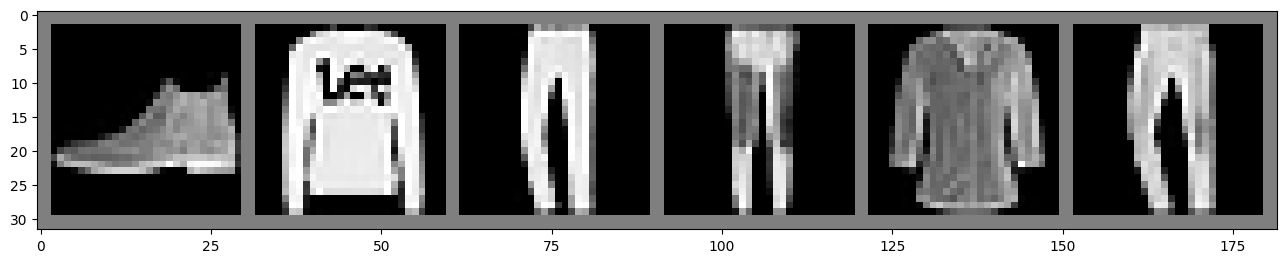

In [ ]:
import torchvision
import numpy as np

dataiter = iter(test_loader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:6]))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1,
        2, 6, 4, 6, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


In [ ]:
print("".join("{}, ".format(labels_map[int(predicted[j].numpy())]) for j in range(6)))

Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, 


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

87.88
